In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit


$ \mathcal{H} = - \sum_{i,j=0}^{N-1} J_{ij}s_is_j + N\epsilon \overline{s}^2 $

$J_{ij} = J_{ji} = 1/2$


# Funciones de inicialización y algoritmos de evolución

In [2]:
# Genera una configuracion de spines aleatorios
def initial_state(rng, n):
    return 2*rng.integers(0,2, size= ((n,n))) -1

def initial_state1(rng, n):
    return np.ones((n, n), dtype=int)

def initial_state_three_quarters_plus_one(rng, n):
    total_spins = n * n
    num_plus_one = int(0.75 * total_spins)
    num_minus_one = total_spins - num_plus_one

    # Create an array with 75% +1 and 25% -1
    spins = np.array([1] * num_plus_one + [-1] * num_minus_one)

    # Shuffle the array to randomly distribute +1 and -1
    rng.shuffle(spins)

    # Reshape to an n x n grid
    grid = spins.reshape((n, n))

    return grid

#Paso de evolución con Glauber

def mc_single_step_Glauber(rng, grid, beta, epsilon, J, t): #Está implementado el algoritmo de Glauber.
    n = grid.shape[0]
    ii = rng.integers(0, n)
    jj = rng.integers(0, n)
    # Calcula el cambio de energía para invertir el espín
    DeltaE = 2*J*grid[ii, jj]*(grid[(ii+1)%n, jj] + grid[(ii-1+n)%n, jj] + grid[ii, (jj+1)%n] + grid[ii, (jj-1+n)%n]) - 2*epsilon*(1/(n))*grid[ii,jj]*(np.sum(grid)-grid[ii,jj])
    # Calcula la probabilidad de invertir el espín según Glauber
    # Calculate the probability of spin flip using a stable method
    if beta * DeltaE > 700:
        P = 0
    else:
        P = 1 / (1 + np.exp(beta * DeltaE))
    # Decide si invertir el espín basado en la probabilidad de Glauber
    if rng.random() < P:
        grid[ii, jj] *= -1

#Función periódica que ilustra eventos periódicos que dan pequeños "empujones" a un candidato




# Realiza un paso completo de monte carlo, t = 1
def mc_full_step(rng, grid, beta, epsilon, update_method):
    n = grid.shape[0]
    n2 = n*n
    for istep in range(0, n2):
        update_method(rng, grid, beta, epsilon)

#Realiza un décimo de paso de Monte Carlo
def mc_tenth_step(rng, grid, beta, epsilon, update_method):
    n = grid.shape[0]
    n2 = round(n*n/10)
    for istep in range(0, n2):
        update_method(rng, grid, beta, epsilon)


@njit
def general_opinion(grid): #Es el promedio de la opinión general
    return np.mean(grid)

def calculate_voter_percentages(grid):

    total_spins = grid.size
    candidate1_percentage = np.sum(grid == 1) / total_spins
    candidate2_percentage = np.sum(grid == -1) / total_spins
    return candidate1_percentage, candidate2_percentage

def seg_term(n, epsilon, oprom):
    s2 = oprom**2
    return n*epsilon*s2



@njit
def compute_energy(grid):
    n = grid.shape[0]
    energy = 0.0
    for ii in range(n):
        for jj in range(n):
            neigh_sum = grid[(ii+1)%n, jj] + grid[(ii-1+n)%n, jj] + grid[ii, (jj+1)%n] + grid[ii, (jj-1+n)%n]
            energy -= grid[ii,jj]*neigh_sum
    return energy/2.0


@njit
def compute_magnetization(grid):
    return np.abs(np.sum(grid))

def calcular_clustering_coefficient_periodico(estado):
    N = estado.shape[0]  # Asumiendo que el estado es una red cuadrada de tamaño N x N
    total_clustering = 0

    # Iterar sobre todos los espines en la red
    for i in range(N):
        for j in range(N):
            # Vecinos con condiciones periódicas
            vecinos = [
                estado[i, (j - 1) % N],  # Abajo
                estado[i, (j + 1) % N],  # Arriba
                estado[(i - 1) % N, j],  # Izquierda
                estado[(i + 1) % N, j]   # Derecha
            ]

            # Contar cuántos vecinos comparten el mismo estado
            mismo_estado_vecinos = sum(estado[i, j] == vecino for vecino in vecinos)

            # Calcular la fracción de vecinos que comparten el mismo estado (todos tienen 4 vecinos)
            clustering_local = mismo_estado_vecinos / 4.0
            total_clustering += clustering_local

    # Promediar sobre todos los espines
    c = total_clustering / (N*N)

    return c



# **Simulación replicación de resultados capítulo II**

Glauber

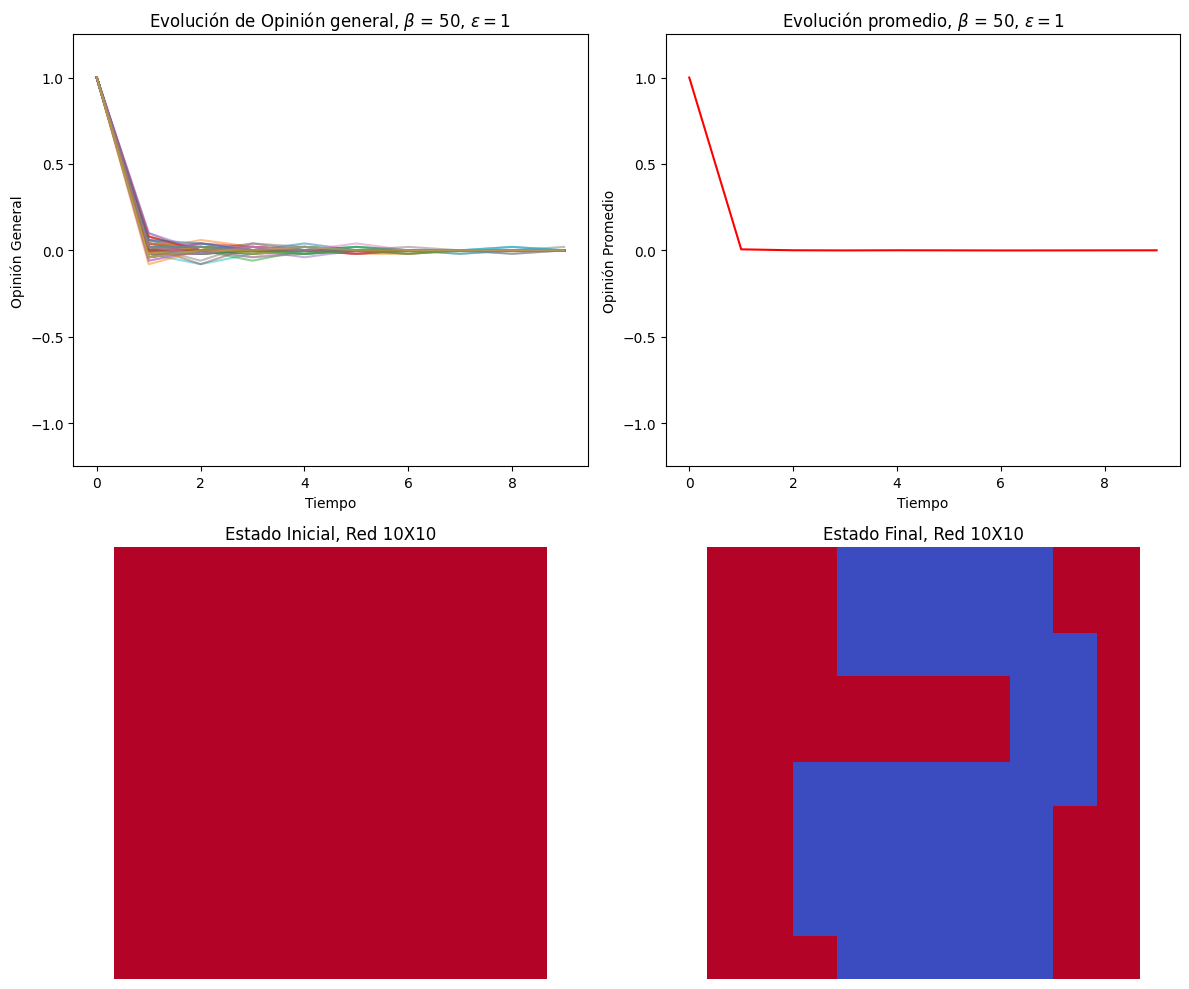

In [ ]:
# Parameters
beta = 50
epsilon = 1
tiempo = 10
N = 10
SEED = [i for i in range(1, 100)]

# Preallocate the list to store the general opinions across all seeds
promedio_go = np.zeros((len(SEED), tiempo))

# Simulation loop
for w, seed in enumerate(SEED):
    rng = np.random.default_rng(seed=seed)
    grid = initial_state1(rng, N)

    # Store the initial state for reference
    if w == 0:  # Just store the initial state from the first run
        initial_grid = grid.copy()

    # Precompute general opinion for the current seed
    go = np.zeros(tiempo)

    for i in range(tiempo):
        go[i] = general_opinion(grid)
        mc_full_step(rng, grid, beta, epsilon, mc_single_step_Glauber)

    # Store the result for this seed
    promedio_go[w] = go

# Calculate the average opinion across all seeds
promedio_final = np.mean(promedio_go, axis=0)

# Create a 2x2 figure layout
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Evolution of Opinion for all seeds
for w in range(len(SEED)):
    ax[0, 0].plot(promedio_go[w], alpha=0.5)
ax[0, 0].set_title(rf'Evolución de Opinión general, $\beta$ = {beta}, $\epsilon = {epsilon}$')
ax[0, 0].set_ylim(-1.25, 1.25)
ax[0, 0].set_xlabel('Tiempo')
ax[0, 0].set_ylabel('Opinión General')

# Plot 2: Average Evolution of Opinion
ax[0, 1].plot(promedio_final, color='red')
ax[0, 1].set_title(rf'Evolución promedio, $\beta$ = {beta}, $\epsilon = {epsilon}$')
ax[0, 1].set_ylim(-1.25, 1.25)
ax[0, 1].set_xlabel('Tiempo')
ax[0, 1].set_ylabel('Opinión Promedio')

# Plot 3: Initial State of the Grid
ax[1, 0].imshow(initial_grid, cmap='coolwarm_r')
ax[1, 0].set_title(rf'Estado Inicial, Red {N}X{N}')
ax[1, 0].axis('off')  # Remove axis for a cleaner look

# Plot 4: Final State of the Grid
ax[1, 1].imshow(grid, cmap='coolwarm')
ax[1, 1].set_title(rf'Estado Final, Red {N}X{N}')
ax[1, 1].axis('off')  # Remove axis for a cleaner look
# Save the figure as a JPG file
plt.savefig('beta50epsilon1.jpg', format='jpg', dpi=300)
# Tight layout and final adjustments
plt.tight_layout()
plt.show()

Simulación normal

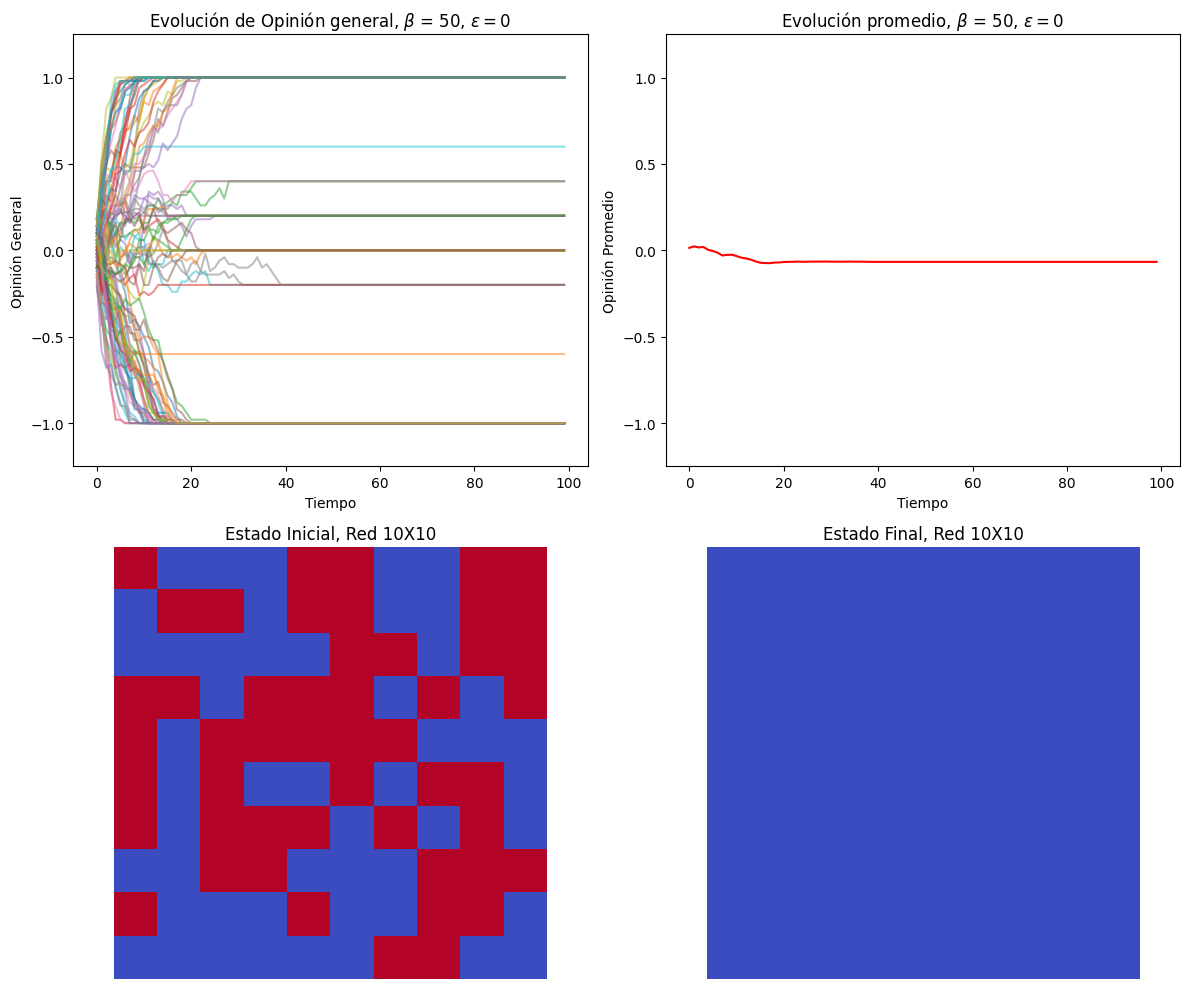

In [ ]:
# Parameters
beta = 50
epsilon = 0
tiempo = 100
N = 10
SEED = [i for i in range(1, 100)]

# Preallocate the list to store the general opinions across all seeds
promedio_go = np.zeros((len(SEED), tiempo))

# Simulation loop
for w, seed in enumerate(SEED):
    rng = np.random.default_rng(seed=seed)
    grid = initial_state(rng, N)

    # Store the initial state for reference
    if w == 0:  # Just store the initial state from the first run
        initial_grid = grid.copy()

    # Precompute general opinion for the current seed
    go = np.zeros(tiempo)

    for i in range(tiempo):
        go[i] = general_opinion(grid)
        mc_full_step(rng, grid, beta, epsilon, mc_single_step_metropolis1)

    # Store the result for this seed
    promedio_go[w] = go

# Calculate the average opinion across all seeds
promedio_final = np.mean(promedio_go, axis=0)

# Create a 2x2 figure layout
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Evolution of Opinion for all seeds
for w in range(len(SEED)):
    ax[0, 0].plot(promedio_go[w], alpha=0.5)
ax[0, 0].set_title(rf'Evolución de Opinión general, $\beta$ = {beta}, $\epsilon = {epsilon}$')
ax[0, 0].set_ylim(-1.25, 1.25)
ax[0, 0].set_xlabel('Tiempo')
ax[0, 0].set_ylabel('Opinión General')

# Plot 2: Average Evolution of Opinion
ax[0, 1].plot(promedio_final, color='red')
ax[0, 1].set_title(rf'Evolución promedio, $\beta$ = {beta}, $\epsilon = {epsilon}$')
ax[0, 1].set_ylim(-1.25, 1.25)
ax[0, 1].set_xlabel('Tiempo')
ax[0, 1].set_ylabel('Opinión Promedio')

# Plot 3: Initial State of the Grid
ax[1, 0].imshow(initial_grid, cmap='coolwarm_r')
ax[1, 0].set_title(rf'Estado Inicial, Red {N}X{N}')
ax[1, 0].axis('off')  # Remove axis for a cleaner look

# Plot 4: Final State of the Grid
ax[1, 1].imshow(grid, cmap='coolwarm')
ax[1, 1].set_title(rf'Estado Final, Red {N}X{N}')
ax[1, 1].axis('off')  # Remove axis for a cleaner look
# Save the figure as a JPG file
#plt.savefig('beta50epsilon0.jpg', format='jpg', dpi=300)
# Tight layout and final adjustments
plt.tight_layout()
plt.show()

Detección de semillas extrañas

# Evolución electorado

**Gráfica elecciones**

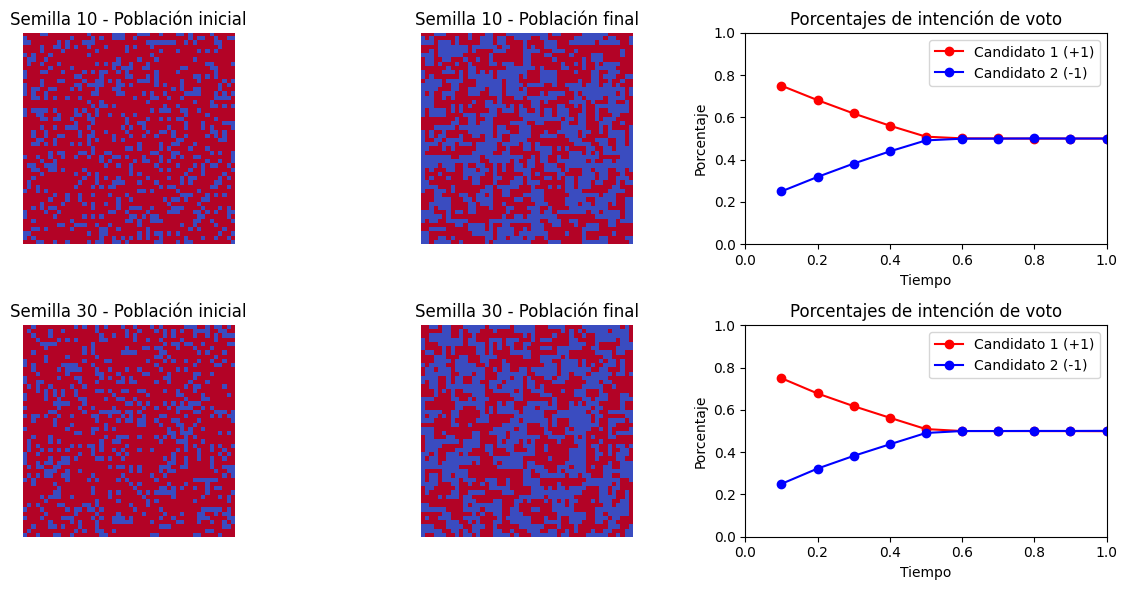

In [ ]:
# Parameters
beta = 50
epsilon = 1
tiempo = 1
N = 50
SEEDS = [10, 30]  # Two seeds for this example
save_times = [0, 5]  # Specific time moments to save

# Dynamic subplot grid: One column for the initial grid, one for the final grid, and one for the line plot
n_cols = 3  # Initial grid, final grid, and line plot
fig, axs = plt.subplots(len(SEEDS), n_cols, figsize=(12, 6))  # Adjust based on number of saves

for seed_idx, SEED in enumerate(SEEDS):
    rng = np.random.default_rng(seed=SEED)
    grid = initial_state_three_quarters_plus_one(rng, N)

    # Capture the initial grid
    initial_grid = grid.copy()

    candidate1_percentages = []
    candidate2_percentages = []

    # Simulation
    total_steps = tiempo * 10  # Total steps considering quarter steps
    time_points = np.arange(0.1, tiempo + 0.1, 0.1)  # Time points in units of 0.1

    for i in range(total_steps):
        # Calculate percentages after each quarter step
        candidate1_pct, candidate2_pct = calculate_voter_percentages(grid)
        candidate1_percentages.append(candidate1_pct)
        candidate2_percentages.append(candidate2_pct)

        # Perform a quarter Monte Carlo step
        mc_tenth_step(rng, grid, beta, epsilon, mc_single_step_Glauber)

    # Capture the final grid after simulation
    final_grid = grid.copy()

    # Plot the initial grid
    ax_initial = axs[seed_idx, 0]  # First column for the initial grid
    ax_initial.imshow(initial_grid, cmap='coolwarm', vmin=-1, vmax=1)
    ax_initial.set_title(f'Semilla {SEED} - Población inicial')
    ax_initial.axis('off')  # Hide axis for grid display

    # Plot the final grid
    ax_final = axs[seed_idx, 1]  # Second column for the final grid
    ax_final.imshow(final_grid, cmap='coolwarm', vmin=-1, vmax=1)
    ax_final.set_title(f'Semilla {SEED} - Población final')
    ax_final.axis('off')  # Hide axis for grid display

    # Line plot for the voter percentages
    ax_percentages = axs[seed_idx, 2]  # Third column for the line plot
    ax_percentages.plot(time_points, candidate1_percentages, marker='o', color='red', label='Candidato 1 (+1)')
    ax_percentages.plot(time_points, candidate2_percentages, marker='o', color='blue', label='Candidato 2 (-1)')
    ax_percentages.set_xlim(0, tiempo)  # Set the x-axis to the full time range
    ax_percentages.set_ylim(0, 1)  # Adjust to 0-1 range to represent percentages
    ax_percentages.set_title('Porcentajes de intención de voto')
    ax_percentages.set_xlabel('Tiempo')
    ax_percentages.set_ylabel('Porcentaje')
    ax_percentages.legend()

# Adjust the layout and presentation
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()

# Save the figure to the current directory
plt.savefig('voter_percentages_initial_final.png')

# Show the figure
plt.show()

# Clustering


In [ ]:


# Parámetros
beta = 0.1
epsilon = 0
tiempo = 10
N = 10
SEED = [i for i in range(1, 101)]  # 100 semillas

# Preallocate the list to store the clustering coefficients across all seeds
clustering_coeffs = np.zeros(len(SEED))  # Para almacenar el clustering coefficient de cada semilla

# Simulation loop
for w, seed in enumerate(SEED):
    rng = np.random.default_rng(seed=seed)
    grid = initial_state1(rng, N)

    # Simulación del modelo de Ising para la semilla actual
    for i in range(tiempo):
        mc_full_step(rng, grid, beta, epsilon, mc_single_step_Glauber)

    # Calcular el clustering coefficient para la semilla actual y almacenarlo
    clustering_coeffs[w] = calcular_clustering_coefficient_periodico(grid)

# Calcular el clustering coefficient promedio sobre todas las semillas
clustering_coefficient_promedio = np.mean(clustering_coeffs)
clustering_coefficient_std = np.std(clustering_coeffs)

# Mostrar el valor del clustering coefficient promedio y su desviación estándar
print(f"Clustering Coefficient Promedio: {clustering_coefficient_promedio:.3f}")
print(f"Desviación Estándar del Clustering Coefficient: {clustering_coefficient_std:.3f}")

Clustering Coefficient Promedio: 0.528
Desviación Estándar del Clustering Coefficient: 0.038


In [ ]:
import numpy as np
import pandas as pd

# Función que ejecuta la simulación para un conjunto de parámetros dados
def ejecutar_simulacion(beta, epsilon, tiempo, N, SEED):
    # Preallocate the list to store the clustering coefficients across all seeds
    clustering_coeffs = np.zeros(len(SEED))  # Para almacenar el clustering coefficient de cada semilla

    # Simulation loop
    for w, seed in enumerate(SEED):
        rng = np.random.default_rng(seed=seed)
        grid = initial_state1(rng, N)

        # Simulación del modelo de Ising para la semilla actual
        for i in range(tiempo):
            mc_full_step(rng, grid, beta, epsilon, mc_single_step_Glauber)

        # Calcular el clustering coefficient para la semilla actual y almacenarlo
        clustering_coeffs[w] = calcular_clustering_coefficient_periodico(grid)

    # Calcular el clustering coefficient promedio y su desviación estándar
    clustering_coefficient_promedio = np.mean(clustering_coeffs)
    clustering_coefficient_std = np.std(clustering_coeffs)

    return clustering_coefficient_promedio, clustering_coefficient_std

# Parámetros generales
tiempo = 10
N = 10
SEED = [i for i in range(1, 101)]  # 100 semillas

# Ejecutar simulaciones para diferentes conjuntos de parámetros
resultados = []

# Parámetros: beta = 0.1, epsilon = 0
beta_1 = 0.1
epsilon_1 = 0
promedio_1, std_1 = ejecutar_simulacion(beta_1, epsilon_1, tiempo, N, SEED)
resultados.append({"Beta": beta_1, "Epsilon": epsilon_1, "Promedio Clustering": promedio_1, "Desviación Estándar": std_1})

# Parámetros: beta = 50, epsilon = 1
beta_2 = 50
epsilon_2 = 1
promedio_2, std_2 = ejecutar_simulacion(beta_2, epsilon_2, tiempo, N, SEED)
resultados.append({"Beta": beta_2, "Epsilon": epsilon_2, "Promedio Clustering": promedio_2, "Desviación Estándar": std_2})

# Convertir los resultados en un DataFrame de Pandas para mejor visualización
df_resultados = pd.DataFrame(resultados)

# Mostrar la tabla con los resultados
print(df_resultados)

   Beta  Epsilon  Promedio Clustering  Desviación Estándar
0   0.1        0               0.5279             0.038165
1  50.0        1               0.8125             0.031221


In [ ]:
#Paso de evolución con Glauber

def mc_single_step_Glauber_REP(rng, grid, beta, epsilon=0, J=0.5): #Está implementado el algoritmo de Glauber.
    n = grid.shape[0]
    ii = rng.integers(0, n)
    jj = rng.integers(0, n)
    # Calcula el cambio de energía para invertir el espín
    DeltaE = 2*J*grid[ii, jj]*(grid[(ii+1)%n, jj] + grid[(ii-1+n)%n, jj] + grid[ii, (jj+1)%n] + grid[ii, (jj-1+n)%n]) - 2*epsilon*(1/(n))*grid[ii,jj]*(np.sum(grid)-grid[ii,jj])
    # Calcula la probabilidad de invertir el espín según Glauber
    # Calculate the probability of spin flip using a stable method
    if beta * DeltaE > 700:
        P = 0
    else:
        P = 1 / (1 + np.exp(beta * DeltaE))
    # Decide si invertir el espín basado en la probabilidad de Glauber
    if rng.random() < P:
        grid[ii, jj] *= -1

# Simulación término extra


$H=-\sum_{<i,j>} J s_i s_j+N \bar{\epsilon} \bar{s}^2+\sum_i s_i(B \cos (\omega t)+B)$

Al calcular $\Delta E$ encontramos:

$ \Delta E=2 J s_{i}^*\left(s_{j 0}+s_{j 1}+s_{j 2}+s_{j 3}\right)-2 \frac{\epsilon}{N} s_{i}^*  \sum_{j=0}^{N-1} s_j -2 s_{i}^*(B \cos (\omega \epsilon)+B)$

Es importante poner en el overleaf cómo funciona este término si $B<1$ y $B>1$.Veamos que, si $B<0$ se favorece al candidato +1 y si $B>0$ se favorece al candidato -1. (En el overleaf sí se puede explicar un poco más pausadamente esto)

In [20]:
#Funciones relevantes para la simulación:


#Paso de evolución con Glauber teniendo en cuenta el término extra

def mc_single_step_Glauber_EXTRA(rng, grid, beta, epsilon, J, B, t, w,extra): #Está implementado el algoritmo de Glauber.
    n = grid.shape[0]
    ii = rng.integers(0, n)
    jj = rng.integers(0, n)
    # Calcula el cambio de energía para invertir el espín
    DeltaE =  2*J*grid[ii, jj]*(grid[(ii+1)%n, jj] + grid[(ii-1+n)%n, jj] + grid[ii, (jj+1)%n] + grid[ii, (jj-1+n)%n]) - 2*epsilon*(1/(n))*grid[ii,jj]*(np.sum(grid)-grid[ii,jj])+extra(B,t, grid[ii,jj])
    # Calcula la probabilidad de invertir el espín según Glauber
    # Calculate the probability of spin flip using a stable method
    if beta * DeltaE > 700:
        P = 0
    else:
        P = 1 / (1 + np.exp(beta * DeltaE))
    # Decide si invertir el espín basado en la probabilidad de Glauber
    if rng.random() < P:
        grid[ii, jj] *= -1

#Función que representa el término de ventaja periódica
#Definiremos la frecuencia w como una variable global
def plusperiodico(B, t, s):
    return -2*s*(B*np.cos(w*t)+B+3.3)

# Realiza un décimo de paso de Monte Carlo
def mc_tenth_step_extra(rng, grid, beta, epsilon, update_method, B, t, w, extra):
    n = grid.shape[0]
    n2 = round(n * n / 10)
    for istep in range(0, n2):
        # Agrega el argumento 'extra' en la llamada a update_method
        update_method(rng, grid, beta, epsilon, 0.5, B, t, w, extra)

# Realiza un paso completo de monte carlo, t = 1
def mc_full_step_extra(rng, grid, beta, epsilon, update_method, B, t, w, extra):
    n = grid.shape[0]
    n2 = n*n
    for istep in range(0, n2):
        update_method(rng, grid, beta, epsilon, 0.5, B, t, w, extra)


Evolución electorado, término de ventaja periódica, usando $\beta=50, \epsilon = 1, N = 50, B = 1.0, \omega = 20$. Estos resultados son comparables con los resultados vistos en la sección anterior, correspondiente con la replicación de resultados. Temos matrices 10x10 para las gráficas del primer bloque de código y matrices 50x50 para el segundo bloque (correspondiente a las gráficas ilustrativas de la evolución de la intención de voto).

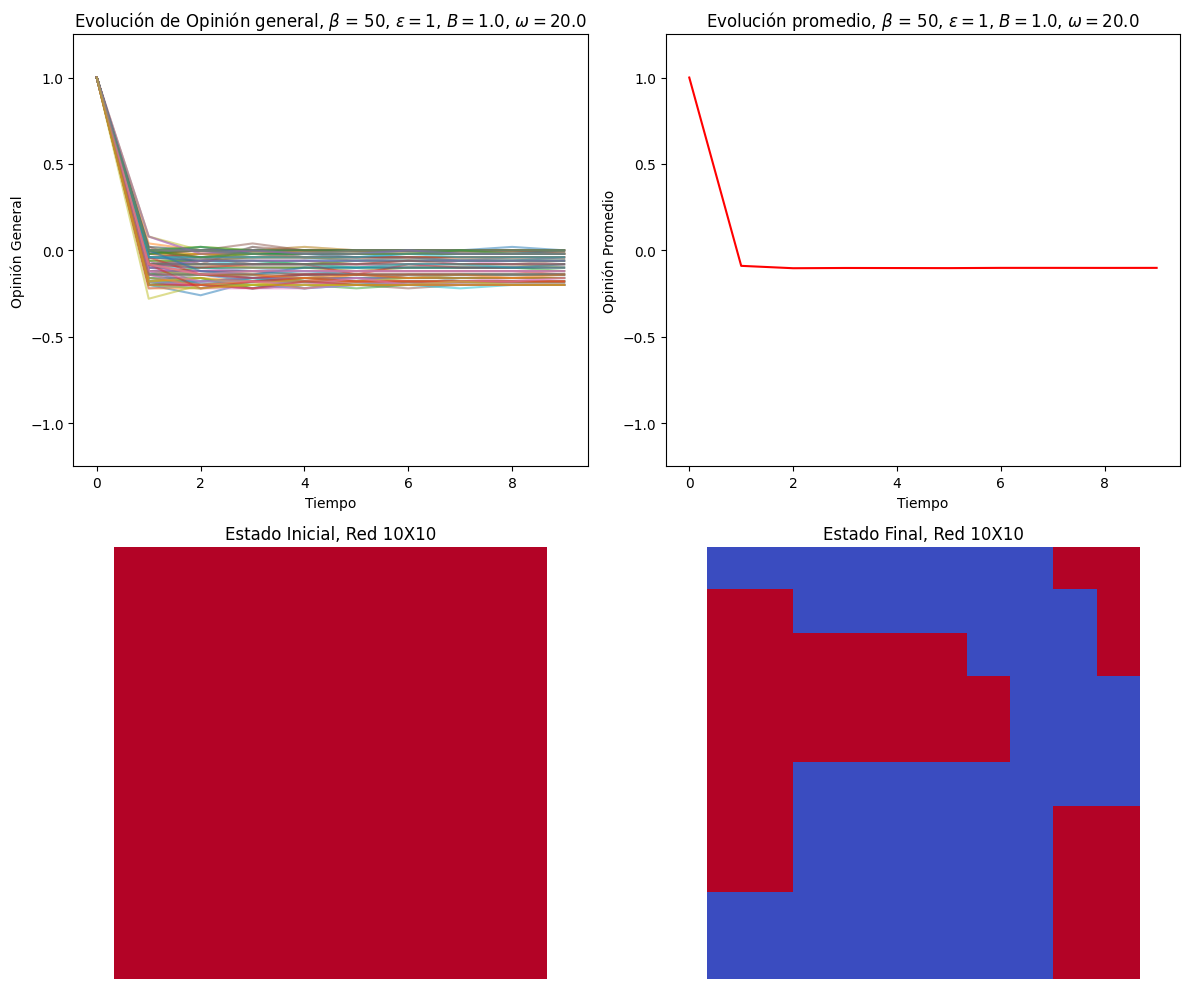

In [16]:
# Parámetros
beta = 50
epsilon = 1
tiempo = 10
N = 10
SEED = [i for i in range(1, 100)]
B = 1.0  # Campo magnético externo
omega = 20.0  # Frecuencia del término periódico

# Preallocate the list to store the general opinions across all seeds
promedio_go = np.zeros((len(SEED), tiempo))

# Simulation loop
for w, seed in enumerate(SEED):
    rng = np.random.default_rng(seed=seed)
    grid = initial_state1(rng, N)

    # Store the initial state for reference
    if w == 0:  # Just store the initial state from the first run
        initial_grid = grid.copy()

    # Precompute general opinion for the current seed
    go = np.zeros(tiempo)

    for i in range(tiempo):
        go[i] = general_opinion(grid)
        mc_full_step_extra(rng, grid, beta, epsilon, mc_single_step_Glauber_EXTRA, B, tiempo, omega, plusperiodico)

    # Store the result for this seed
    promedio_go[w] = go

# Calculate the average opinion across all seeds
promedio_final = np.mean(promedio_go, axis=0)

# Create a 2x2 figure layout
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Evolution of Opinion for all seeds
for w in range(len(SEED)):
    ax[0, 0].plot(promedio_go[w], alpha=0.5)
ax[0, 0].set_title(rf'Evolución de Opinión general, $\beta$ = {beta}, $\epsilon = {epsilon}$, $B={B}$, $\omega ={omega}$')
ax[0, 0].set_ylim(-1.25, 1.25)
ax[0, 0].set_xlabel('Tiempo')
ax[0, 0].set_ylabel('Opinión General')

# Plot 2: Average Evolution of Opinion
ax[0, 1].plot(promedio_final, color='red')
ax[0, 1].set_title(rf'Evolución promedio, $\beta$ = {beta}, $\epsilon = {epsilon}$, $B={B}$, $\omega ={omega}$')
ax[0, 1].set_ylim(-1.25, 1.25)
ax[0, 1].set_xlabel('Tiempo')
ax[0, 1].set_ylabel('Opinión Promedio')

# Plot 3: Initial State of the Grid
ax[1, 0].imshow(initial_grid, cmap='coolwarm_r')
ax[1, 0].set_title(rf'Estado Inicial, Red {N}X{N}')
ax[1, 0].axis('off')  # Remove axis for a cleaner look

# Plot 4: Final State of the Grid
ax[1, 1].imshow(grid, cmap='coolwarm')
ax[1, 1].set_title(rf'Estado Final, Red {N}X{N}')
ax[1, 1].axis('off')  # Remove axis for a cleaner look
# Save the figure as a JPG file
plt.savefig('beta50epsilon1extra.jpg', format='jpg', dpi=300)
# Tight layout and final adjustments
plt.tight_layout()
plt.show()

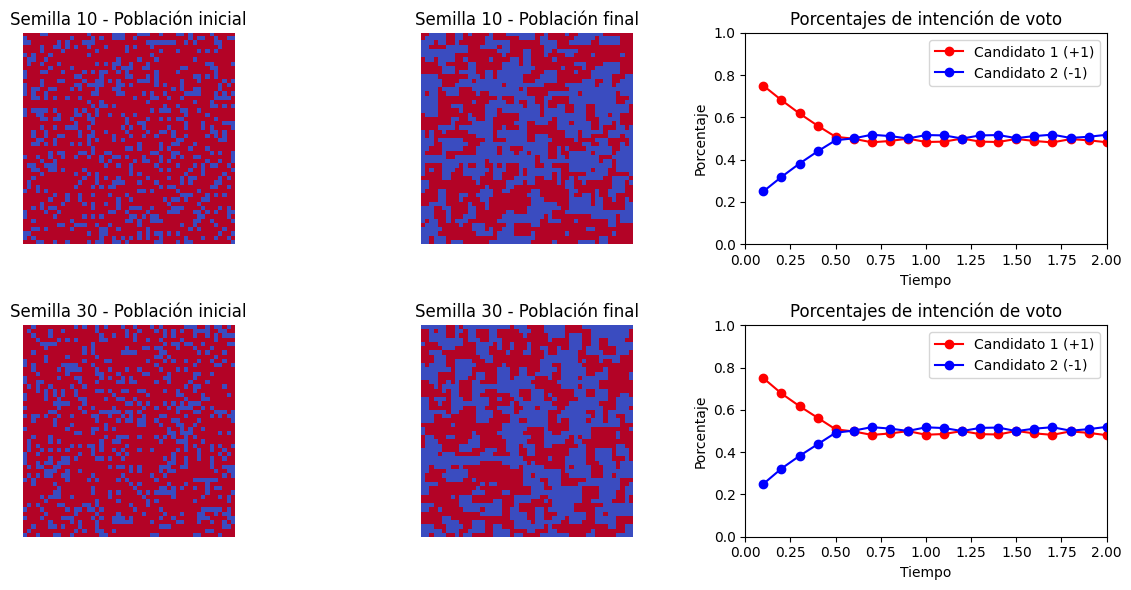

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Variables y parámetros
beta = 50
epsilon = 1
tiempo = 2
N = 50
SEEDS = [10, 30]  # Dos semillas para este ejemplo
save_times = [0, 5]  # Momentos específicos en el tiempo para guardar
B = 1.0  # Campo magnético externo
w = 20.0  # Frecuencia del término periódico



# Grid dinámico de subplots: Una columna para la grilla inicial, otra para la grilla final y otra para el gráfico de líneas
n_cols = 3  # Grid inicial, grid final y gráfico de líneas
fig, axs = plt.subplots(len(SEEDS), n_cols, figsize=(12, 6))  # Ajustar basado en el número de guardados

for seed_idx, SEED in enumerate(SEEDS):
    rng = np.random.default_rng(seed=SEED)
    grid = initial_state_three_quarters_plus_one(rng, N)  # Asumiendo que esta función inicializa la grilla

    # Capturar la grilla inicial
    initial_grid = grid.copy()

    candidate1_percentages = []
    candidate2_percentages = []

    # Simulación
    total_steps = tiempo * 10  # Total de pasos considerando pasos de décimos
    time_points = np.arange(0.1, tiempo + 0.1, 0.1)  # Puntos de tiempo en unidades de 0.1

    for i in range(total_steps):
        # Tiempo actual
        current_time = (i + 1) * 0.1

        # Calcular los porcentajes después de cada décimo de paso
        candidate1_pct, candidate2_pct = calculate_voter_percentages(grid)
        candidate1_percentages.append(candidate1_pct)
        candidate2_percentages.append(candidate2_pct)

        # Realizar un décimo de paso de Monte Carlo con el término extra
        mc_tenth_step_extra(rng, grid, beta, epsilon, mc_single_step_Glauber_EXTRA, B, current_time, w, plusperiodico)

    # Capturar la grilla final después de la simulación
    final_grid = grid.copy()

    # Graficar la grilla inicial
    ax_initial = axs[seed_idx, 0]  # Primera columna para la grilla inicial
    ax_initial.imshow(initial_grid, cmap='coolwarm', vmin=-1, vmax=1)
    ax_initial.set_title(f'Semilla {SEED} - Población inicial')
    ax_initial.axis('off')  # Ocultar ejes para mostrar la grilla

    # Graficar la grilla final
    ax_final = axs[seed_idx, 1]  # Segunda columna para la grilla final
    ax_final.imshow(final_grid, cmap='coolwarm', vmin=-1, vmax=1)
    ax_final.set_title(f'Semilla {SEED} - Población final')
    ax_final.axis('off')  # Ocultar ejes para mostrar la grilla

    # Gráfico de líneas para los porcentajes
    ax_percentages = axs[seed_idx, 2]  # Tercera columna para el gráfico de líneas
    ax_percentages.plot(time_points, candidate1_percentages, marker='o', color='red', label='Candidato 1 (+1)')
    ax_percentages.plot(time_points, candidate2_percentages, marker='o', color='blue', label='Candidato 2 (-1)')
    ax_percentages.set_xlim(0, tiempo)  # Establecer el eje x para todo el rango de tiempo
    ax_percentages.set_ylim(0, 1)  # Ajustar el rango a 0-1 para representar porcentajes
    ax_percentages.set_title('Porcentajes de intención de voto')
    ax_percentages.set_xlabel('Tiempo')
    ax_percentages.set_ylabel('Porcentaje')
    ax_percentages.legend()

# Ajustar el layout y presentación
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.tight_layout()

# Guardar la figura en el directorio actual
plt.savefig('voter_percentages_initial_finalextra.png')

# Mostrar la figura
plt.show()

**Coeficiente de clustering**

In [13]:
#Parámetros
beta = 50
epsilon = 1
tiempo = 10
N = 10
SEED = [i for i in range(1, 100)]
B = 1.0  # Campo magnético externo
omega = 20.0  # Frecuencia del término periódico

# Preallocate the list to store the clustering coefficients across all seeds
clustering_coeffs = np.zeros(len(SEED))  # Para almacenar el clustering coefficient de cada semilla

# Simulation loop
for w, seed in enumerate(SEED):
    rng = np.random.default_rng(seed=seed)
    grid = initial_state1(rng, N)

    # Simulación del modelo de Ising para la semilla actual
    for i in range(tiempo):
        mc_full_step_extra(rng, grid, beta, epsilon, mc_single_step_Glauber_EXTRA, B, tiempo, omega, plusperiodico)

    # Calcular el clustering coefficient para la semilla actual y almacenarlo
    clustering_coeffs[w] = calcular_clustering_coefficient_periodico(grid)

# Calcular el clustering coefficient promedio sobre todas las semillas
clustering_coefficient_promedio = np.mean(clustering_coeffs)
clustering_coefficient_std = np.std(clustering_coeffs)

# Mostrar el valor del clustering coefficient promedio y su desviación estándar
print(f"Clustering Coefficient Promedio: {clustering_coefficient_promedio:.3f}")
print(f"Desviación Estándar del Clustering Coefficient: {clustering_coefficient_std:.3f}")

Clustering Coefficient Promedio: 0.825
Desviación Estándar del Clustering Coefficient: 0.027


# Elecciones USA

En casos como el de Estados Unidos, en el que aunque el electorado está dividido y se tienen evidentes oscilaciones en la opinión pública, se puede apreciar que la candidata demócrata tiene una pequeña ventaja subyacente, pues desde que tomó el liderato en las encuestas nacionales a finales de julio, no ha cedido el liderato. Como podemos ver en la siguiente gráfica de promedio de encuestas (fuente: https://www.natesilver.net/p/nate-silver-2024-president-election-polls-model) 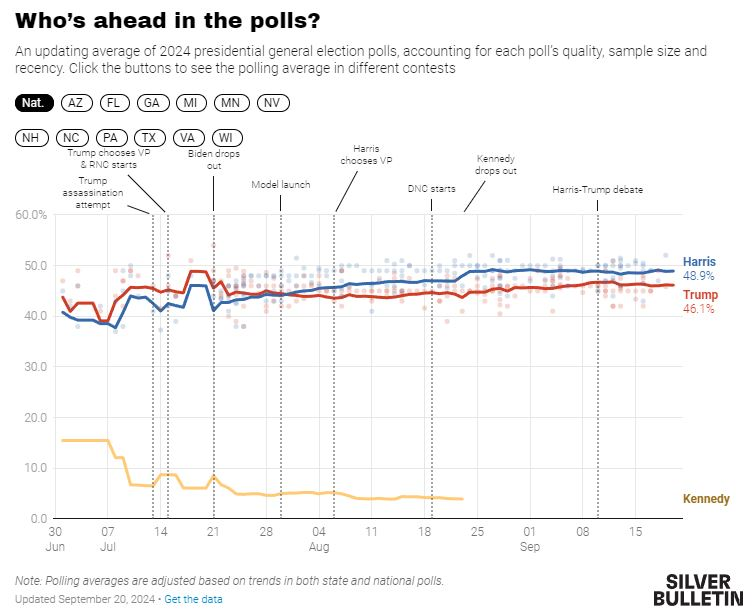

Ahora bien, ¿cómo podríamos dar cuenta de este comportamiento? Podríamos hacer que el término cosenoidal del Hamiltoniano oscile alrededor de la ventaja promedio que tuvieron los candidatos demócratas en 2016 (2.1%) y 2020 (4.5%) (fuente: https://en.wikipedia.org/wiki/2020_United_States_presidential_election y https://en.wikipedia.org/wiki/2016_United_States_presidential_election). Adicionalmente, para que el "piso" de votación demócrata sea la obtenida por Hillary Clinton en 2016 y el "techo" la votación obtenida por Joe Biden en 2020, haremos que $B=1.2$. Así pues, podríamos modificar el Hamiltoniano para que sea:

$H=-\sum_{<i,j>} J s_i s_j+N \bar{\epsilon} \bar{s}^2+\sum_i s_i(B \cos (\omega t)+B+3.3)$

Con esto, si promediamos la intención de voto de 100 simulaciones con diferentes semillas, todas con una condición inicial favorable para el candidato +1 (En este caso, haremos que el candidato rojo, o en el contexto actual Donald Trump, empiece con una ventaja de 75% a 25%), podemos obtener un resultado que replica al electorado estadounidense actual, en el que el cambio de candidato de Joe Biden por Kamala Harris reflejó un retorno a lo que venía sucediendo en las elecciones presidenciales anteriores. El término extra representa entonces una ventaja demócrata, que varía en magnitud dependiendo de eventos que van sucediendo en la campaña, que concuerda con lo vusto en las encuestas para la elección del presente año. Las condiciones iniciales se to

Nota: hay que revisar la interpretación del tiempo, en cuanto a qué significa, ¿1 = 1 año? ¿1 = 1 mes? Hay que poner eso en el overleaf.

En esta simulación estamos teniendo omega = 20.

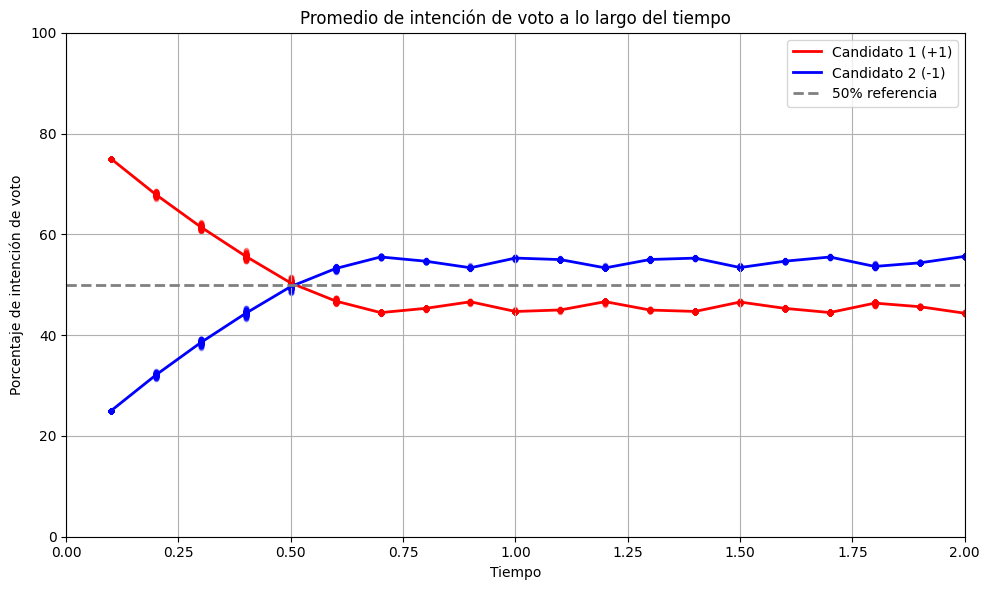

In [25]:


# Variables y parámetros
beta = 50
epsilon = 1
tiempo = 2
N = 50
SEEDS = [i for i in range(1, 100)]  # Varias semillas para promediar
B = 1.2
w = 20.0  # Frecuencia del término periódico

# Simulación
total_steps = tiempo * 10  # Total de pasos considerando pasos de décimos
time_points = np.arange(0.1, tiempo + 0.1, 0.1)  # Puntos de tiempo en unidades de 0.1

# Inicializar listas para almacenar los promedios
average_candidate1_percentages = np.zeros(len(time_points))
average_candidate2_percentages = np.zeros(len(time_points))

# Crear la figura
plt.figure(figsize=(10, 6))

# Realizar simulaciones para cada semilla
for SEED in SEEDS:
    rng = np.random.default_rng(seed=SEED)
    grid = initial_state_three_quarters_plus_one(rng, N)  # Inicializar la grilla

    candidate1_percentages = []
    candidate2_percentages = []

    for i in range(total_steps):
        # Tiempo actual
        current_time = (i + 1) * 0.1

        # Calcular los porcentajes después de cada décimo de paso
        candidate1_pct, candidate2_pct = calculate_voter_percentages(grid)  # Calcular los porcentajes
        candidate1_percentages.append(candidate1_pct)
        candidate2_percentages.append(candidate2_pct)

        # Realizar un décimo de paso de Monte Carlo con el término extra
        mc_tenth_step_extra(rng, grid, beta, epsilon, mc_single_step_Glauber_EXTRA, B, current_time, w, plusperiodico)

    # Convertir a numpy array para mejor manejo
    candidate1_percentages = np.array(candidate1_percentages)
    candidate2_percentages = np.array(candidate2_percentages)

    # Graficar puntos de cada simulación
    plt.scatter(time_points, candidate1_percentages * 100, color='red', alpha=0.3, s=10)  # Puntos para Candidato 1
    plt.scatter(time_points, candidate2_percentages * 100, color='blue', alpha=0.3, s=10)  # Puntos para Candidato 2

    # Sumar los porcentajes obtenidos a las listas de promedios
    average_candidate1_percentages += candidate1_percentages
    average_candidate2_percentages += candidate2_percentages

# Calcular el promedio dividiendo por el número de semillas
average_candidate1_percentages = (average_candidate1_percentages / len(SEEDS)) * 100
average_candidate2_percentages = (average_candidate2_percentages / len(SEEDS)) * 100

# Graficar las líneas del promedio
plt.plot(time_points, average_candidate1_percentages, color='red', label='Candidato 1 (+1)', linewidth=2)
plt.plot(time_points, average_candidate2_percentages, color='blue', label='Candidato 2 (-1)', linewidth=2)

# Agregar la línea de referencia en el 50%
plt.axhline(y=50, color='gray', linestyle='--', linewidth=2, label='50% referencia')

# Configuración del gráfico
plt.title('Promedio de intención de voto a lo largo del tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Porcentaje de intención de voto')
plt.xlim(0, tiempo)
plt.ylim(0, 100)
plt.legend()

# Ajustar el layout y mostrar la figura
plt.grid(True)
plt.tight_layout()
plt.savefig('voter_average_percentages_with_points_and_reference.png')
plt.show()


Importante poner en la parte de análisis de resultados o en conclusiones que para mejorar este modelo se podría, por ejemplo, tener en cuenta que el término de sociedad dividida que da cuenta de las encuestas tenga algún tipo de error aleatorio para que la situación de cada votante sea más cercana a la realidad en la que las encuestas no muestran realmente la opinión total, sino un estimado.